In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.FCPython import createPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import matplotlib.patches as plt_patches
import matplotlib.patheffects as plt_eff
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.patches as plt_patches

In [5]:
class Pitch(object):
    def __init__(self, xmax_data, ymax_data, length = 120, width = 80, padding = 5):
        self.length = length
        self.width = width
        
        self.xmax_data = xmax_data
        self.ymax_data = ymax_data
        
        self.xlimit = (-padding, self.length + padding)
        self.ylimit = (-padding, self.width + padding)
        
        self.penalty_area_length = 18
        self.penalty_area_width = 44
        self.small_area_length = 6
        self.small_area_width = 20
        self.penalty_kick_length = 12
        self.center_radius = 10
        self.goal_width = 8

    def get_components(self):
        rect, circ = plt_patches.Rectangle, plt_patches.Circle
        
        components = {
            "border": (rect, {"xy": (0, 0), "width": self.length, "height": self.width}),
            "left_circle": (circ, {"xy": (self.penalty_kick_length, self.width/2),
                                   "radius": self.center_radius}),
            "right_circle": (circ, {"xy": (self.length - self.penalty_kick_length, self.width/2),
                                    "radius": self.center_radius}),
            "left_penalty": (rect, {"xy": (0, (self.width/2) - (self.penalty_area_width/2)),
                                    "width": self.penalty_area_length,"height": self.penalty_area_width}),
            "right_penalty": (rect, {"xy": (self.length, (self.width/2)-(self.penalty_area_width/2)),
                                    "width": -self.penalty_area_length,"height": self.penalty_area_width}),
            "left_pk_dot": (circ, {"xy": (self.penalty_kick_length, self.width/2),
                                   "radius": 0.2, "facecolor": (0, 0, 0, 1)}),
            "right_pk_dot": (circ, {"xy": (self.length - self.penalty_kick_length, self.width/2),
                                   "radius": 0.2, "facecolor": (0, 0, 0, 1)}),
            "left_small_area": (rect, {"xy": (0, (self.width/2)-(self.small_area_width/2)),
                        "width": self.small_area_length, "height": self.small_area_width}),
            "right_small_area": (rect, {"xy": (self.length, (self.width/2)-(self.small_area_width/2)),
                        "width": -self.small_area_length, "height": self.small_area_width}),
            "half_circle": (circ, {"xy": (self.length/2, self.width/2), "radius": self.center_radius}),
            "half_line": (rect, {"xy": (self.length/2, 0), "width": 0, "height": self.width}),
            "half_dot": (circ, {"xy": (self.length/2, self.width/2), "radius": 0.2, "facecolor": (0, 0, 0, 1)}),
            "post_left_top": (circ, {"xy": (0, self.width/2 + self.goal_width/2), "radius": 0.2}),
            "post_left_bot": (circ, {"xy": (0, self.width/2 - self.goal_width/2), "radius": 0.2}),
            "post_right_top": (circ, {"xy": (self.length, self.width/2 + self.goal_width/2), "radius": 0.2}),
            "post_right_bot": (circ, {"xy": (self.length, self.width/2 - self.goal_width/2), "radius": 0.2}),    
        }
        
        patches = list()
        pitch_constants = {"linewidth": 1, "facecolor": (1, 1, 1, 1), "edgecolor": (0, 0, 0, 1)}
        
        for __, (shape, params) in components.items():
            shape_attributes = pitch_constants.copy()
            for param, value in params.items():
                shape_attributes[param] = value
            patches.append(shape(**shape_attributes))
        
        return patches
    
    def get_adjusted_x(self, x):
        return x * (self.length / self.xmax_data)

    def get_adjusted_y(self, y):
        return y * (self.width / self.ymax_data)
        
    def draw_lines(self, ax, lines, graph_params = None):
        params = {"length_includes_head": True, "head_width": 2, "head_length": 2,
                  "width": 0.5, "facecolor": (0, 0, 0, 0.5), "edgecolor": (0, 0, 0, 0)}
        
        if graph_params is not None:
            params.update(graph_params)
                
        for start_x, start_y, end_x, end_y in lines:
            dx = end_x - start_x
            dy = end_y - start_y

            attributes = {"x": self.get_adjusted_x(start_x), "y": self.get_adjusted_y(start_y),
                          "dx": self.get_adjusted_x(dx), "dy": self.get_adjusted_y(dy)}
            ax.add_patch(plt_patches.FancyArrow(**attributes, **params))

    def draw_players(self, ax, points, labels, fontsize = 7):
        for i, label in enumerate(labels):
            x, y = points[i]
            ax.text(self.get_adjusted_x(x), self.get_adjusted_y(y), label,
                    fontsize = fontsize, ha = "center", va = "center")

    def draw_points(self, ax, points, graph_params = None, numbers = None):
        params = {"linewidth": 1, "facecolor": "cornflowerblue",
                  "edgecolor": "k", "linewidth": 2, "radius": 2}
        
        if graph_params is not None:
            params.update(graph_params)
            
        for x, y in points:
            attributes = {"xy": (self.get_adjusted_x(x), self.get_adjusted_y(y))}
            ax.add_patch(plt_patches.Circle(**attributes, **params))
        
        if numbers is not None:
            for i, number in enumerate(numbers):
                x, y = points[i]
                ax.text(self.get_adjusted_x(x), self.get_adjusted_y(y), number,
                        fontsize = 14, fontweight = "bold", color = "w", ha = "center", va = "center")
            
    def draw(self, ax):
        for patch in self.get_components():
            ax.add_patch(patch)

---

In [6]:
METRICA_BASE_PATH = "../../sample-data/data"

In [7]:
os.listdir(METRICA_BASE_PATH)

['Sample_Game_1', 'Sample_Game_2', 'Sample_Game_3']

---

In [121]:
target_match = "Sample_Game_2"

events = pd.read_csv(f"{METRICA_BASE_PATH}/{target_match}/{target_match}_RawEventsData.csv")

In [122]:
len(events)

1935

In [123]:
events.Type.value_counts()

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

In [124]:
events.columns

Index(['Team', 'Type', 'Subtype', 'Period', 'Start Frame', 'Start Time [s]',
       'End Frame', 'End Time [s]', 'From', 'To', 'Start X', 'Start Y',
       'End X', 'End Y'],
      dtype='object')

In [125]:
events["Start X"].min(), events["Start X"].max()

(-0.01, 1.03)

In [126]:
pitch_length_meters = 105
pitch_width_meters = 68

x_cols = [col for col in events.columns if col[-1].lower() == "x"]
y_cols = [col for col in events.columns if col[-1].lower() == "y"]

events[x_cols] = np.abs(events[x_cols])
events[y_cols] = np.abs(events[y_cols])



In [127]:
events["Start X"].min(), events["Start X"].max(), events["Start Y"].min(), events["Start Y"].max()

(0.0, 1.03, 0.0, 1.02)

In [128]:
home_events = events[events["Team"] == "Home"]
away_events = events[events["Team"] == "Away"]

In [129]:
home_shots = home_events[home_events.Type == "SHOT"]
away_shots = away_events[away_events.Type == "SHOT"]

home_goals = home_shots[home_shots["Subtype"].str.contains("-GOAL")].copy()
away_goals = away_shots[away_shots["Subtype"].str.contains("-GOAL")].copy()

In [130]:
home_goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,0.05,0.55,0.01,0.53
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,0.95,0.52,1.01,0.53
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,0.79,0.58,1.01,0.54


In [131]:
events.iloc[185:199]

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
185,Away,CHALLENGE,GROUND-WON,1,11519,460.76,11519,460.76,Player22,NaN,0.24,0.39,NaN,NaN
186,Away,CHALLENGE,TACKLE-LOST,1,11534,461.36,11534,461.36,Player22,NaN,0.25,0.41,NaN,NaN
187,Away,BALL LOST,THEFT,1,11534,461.36,11534,461.36,Player22,NaN,0.25,0.41,NaN,NaN
188,Home,CHALLENGE,TACKLE-WON,1,11641,465.64,11641,465.64,Player7,NaN,0.37,0.51,NaN,NaN
189,Home,RECOVERY,THEFT,1,11641,465.64,11641,465.64,Player7,NaN,0.37,0.51,NaN,NaN
190,Home,PASS,NaN,1,11647,465.88,11685,467.40,Player7,Player10,0.37,0.51,0.30,0.50
191,Home,PASS,NaN,1,11685,467.40,11703,468.12,Player10,Player5,0.30,0.50,0.33,0.44
192,Home,PASS,NaN,1,11721,468.84,11744,469.76,Player5,Player9,0.31,0.44,0.21,0.39
193,Home,PASS,NaN,1,11810,472.40,11885,475.40,Player9,Player8,0.19,0.49,0.13,0.87
194,Home,PASS,NaN,1,11958,478.32,11976,479.04,Player8,Player9,0.11,0.86,0.10,0.72


In [ ]:
# The action of the first goal starts at 190

In [132]:
goal_start_frame = events.iloc[198]["Start Frame"]
goal_end_frame = events.iloc[198]["End Frame"]
goal_start_frame, goal_end_frame

(12202, 12212)

In [133]:
def tracking_data(DATADIR,game_id,teamname):
    teamfile = '/Sample_Game_%d/Sample_Game_%d_RawTrackingData_%s_Team.csv' % (game_id,game_id,teamname)
    # First:  deal with file headers so that we can get the player names correct
    csvfile =  open('{}/{}'.format(DATADIR, teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    # construct column names
    jerseys = [x for x in next(reader) if x != ''] # extract player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    # Second: read in tracking data and place into pandas Dataframe
    tracking = pd.read_csv('{}/{}'.format(DATADIR, teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking

In [21]:
tracking_home_file = f"{METRICA_BASE_PATH}/{target_match}/{target_match}_RawTrackingData_Home_Team.csv"
tracking_away_file = f"{METRICA_BASE_PATH}/{target_match}/{target_match}_RawTrackingData_Away_Team.csv"

home_tracking = tracking_data(METRICA_BASE_PATH, 2, "Home")
away_tracking = tracking_data(METRICA_BASE_PATH, 2, "Away")

Reading team: home
Reading team: away


In [22]:
events.iloc[0]["Start Frame"] #kick-off

51

In [161]:
def get_players_positions(data, team):
    pl = dict()
    for col in list(data.index):
        if col.startswith(team):
            jer = col.split("_")[1]
            if jer not in pl.keys():
                pl[jer] = dict()
            coord_name = col.split("_")[2]
            pl[jer][coord_name] = data[col]
    pl = {k: v for k, v in pl.items() if pl[k]["x"] >= 0}
    numbers = list(pl.keys())
    coords = [[v["x"], v["y"]] for __, v in pl.items()]
    return coords, numbers

def plot_action(xmax_data, ymax_data, event, frame_type, home_tracking, away_tracking):    
    home_data = home_tracking.iloc[event[f"{frame_type.capitalize()} Frame"]]
    away_data = away_tracking.iloc[event[f"{frame_type.capitalize()} Frame"]]
    
    home_coords, home_nums = get_players_positions(home_data, "Home")
    away_coords, away_nums = get_players_positions(away_data, "Away")
    
    ball_x, ball_y = home_tracking.iloc[event[f"{frame_type.capitalize()} Frame"]]["ball_x"],\
                     home_tracking.iloc[event[f"{frame_type.capitalize()} Frame"]]["ball_y"]
    
    if ball_x >= 0:
        fig, ax = plt.subplots(figsize = (20, 14))
        p = Pitch(xmax_data, ymax_data)
        p.draw(ax)

        ev_start_x, ev_start_y, ev_end_x, ev_end_y = event["Start X"], event["Start Y"], event["End X"], event["End Y"]

        p.draw_points(ax, points = home_coords, numbers = home_nums)
        p.draw_points(ax, points = away_coords, numbers = away_nums, graph_params = {"facecolor": "coral"})
        p.draw_points(ax, points = [[ball_x, ball_y]], graph_params = {"facecolor": "gainsboro", "radius": 1})

        if frame_type == "start":
            p.draw_lines(ax, lines = [[ev_start_x, ev_start_y, ev_end_x, ev_end_y]])

        plt.xlim(p.xlimit)
        plt.ylim(p.ylimit)
        plt.show()

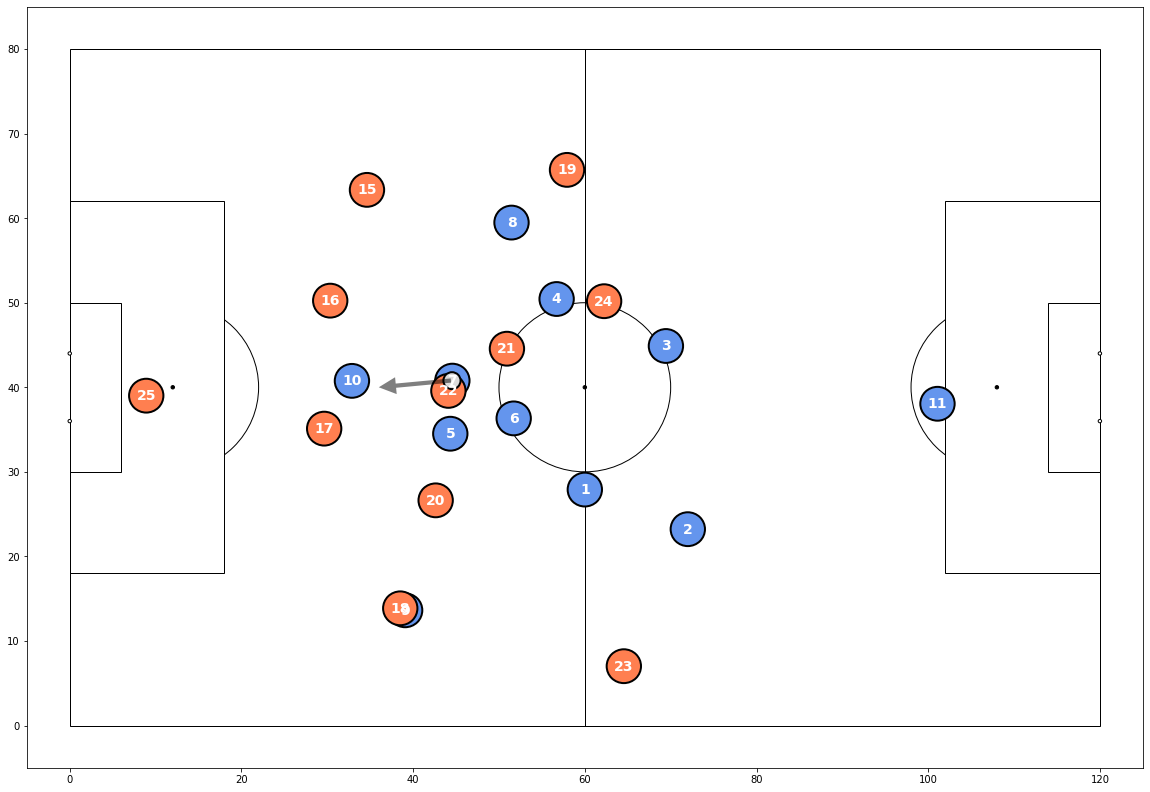

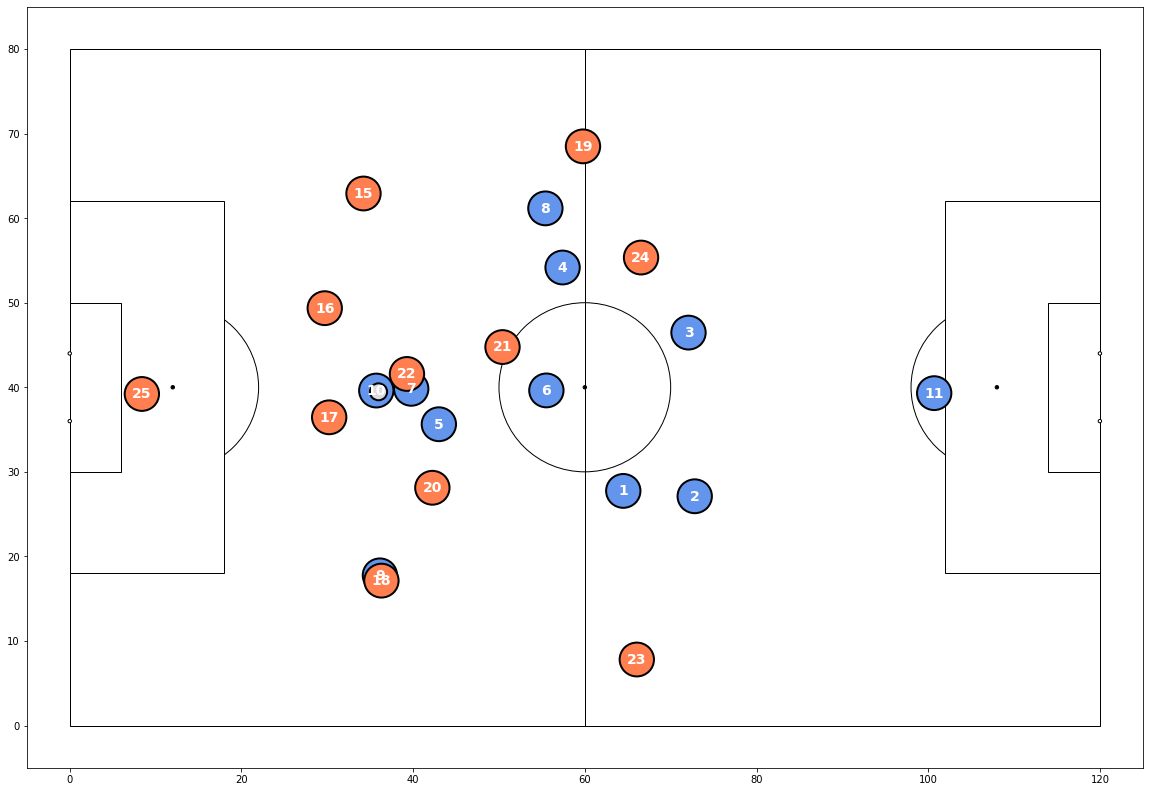

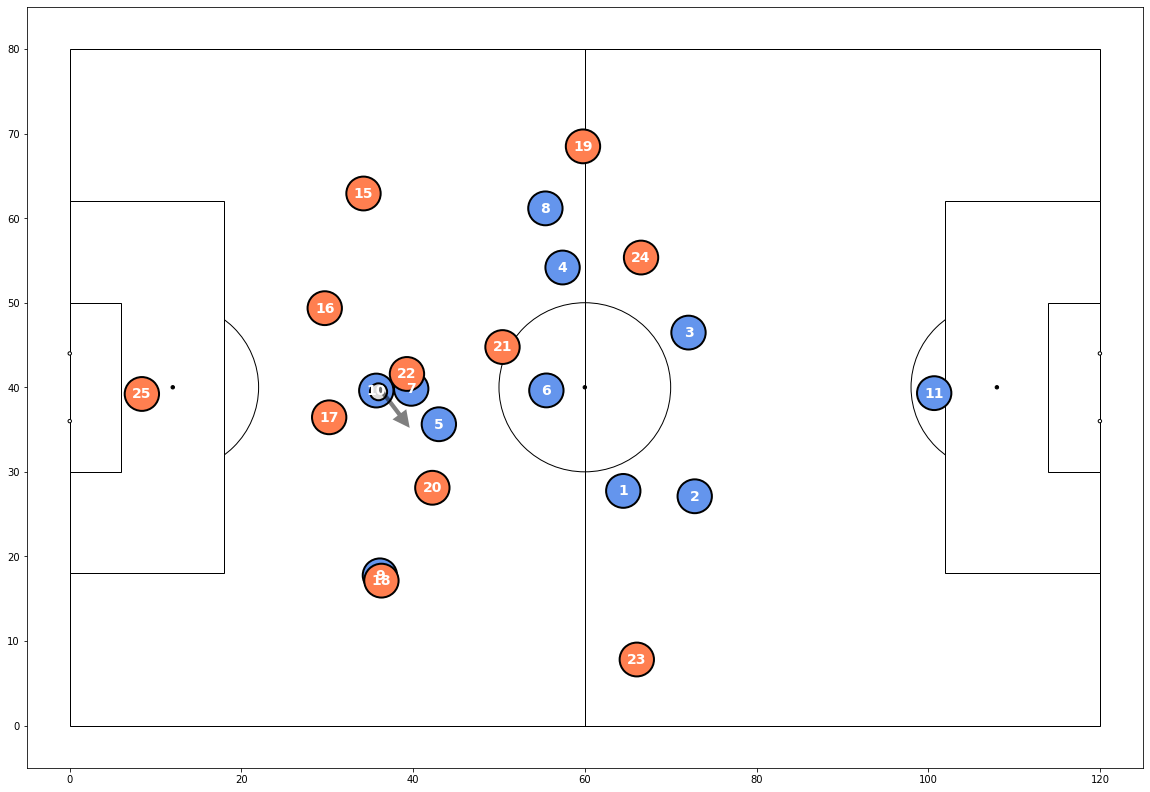

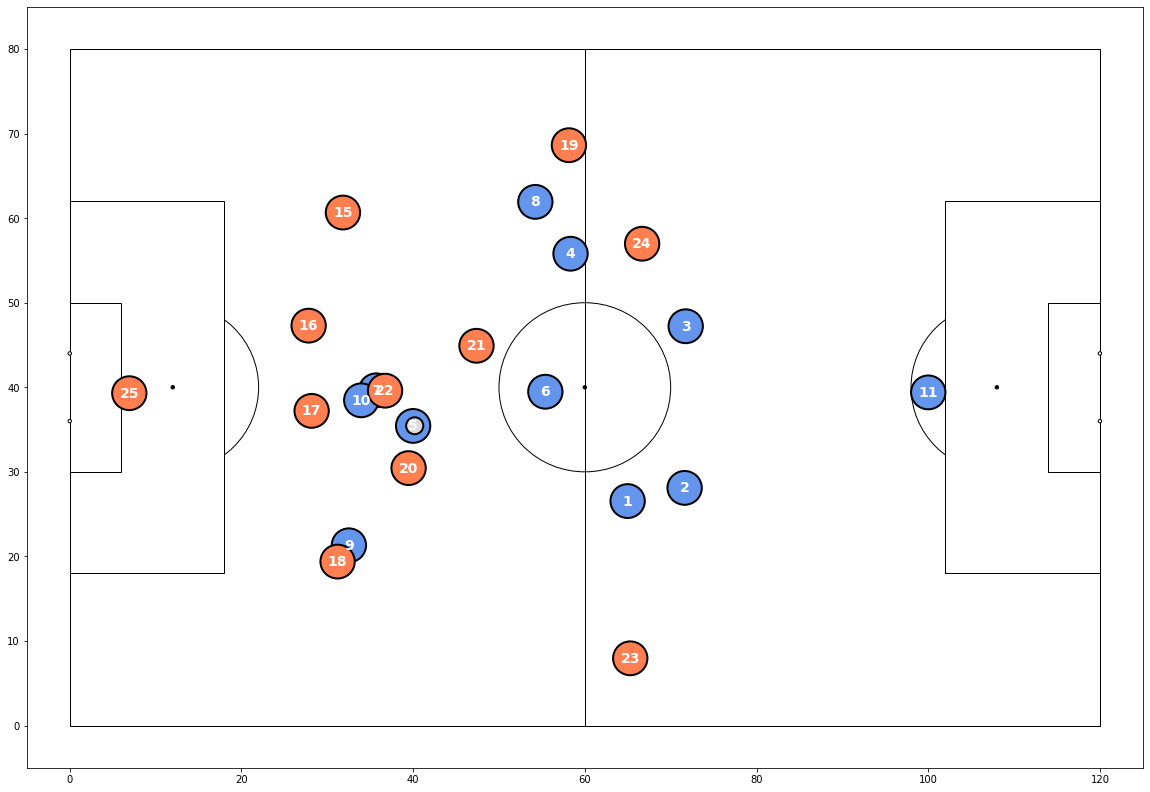

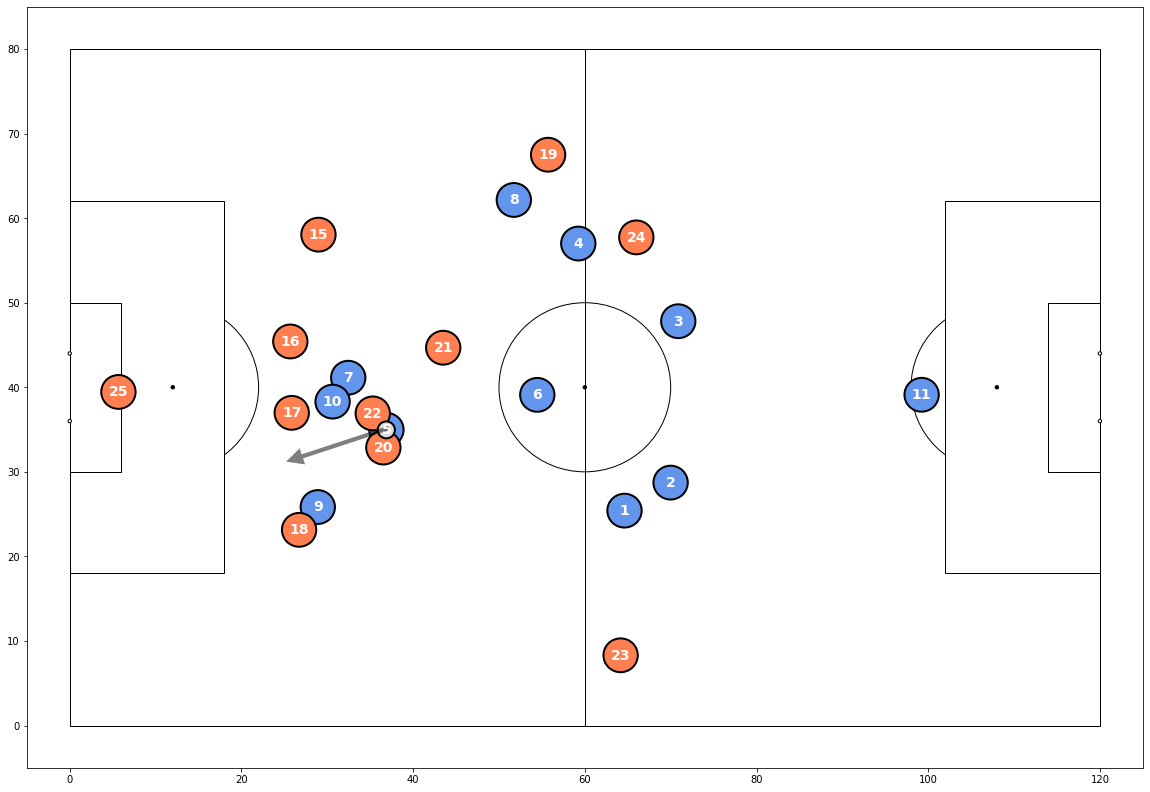

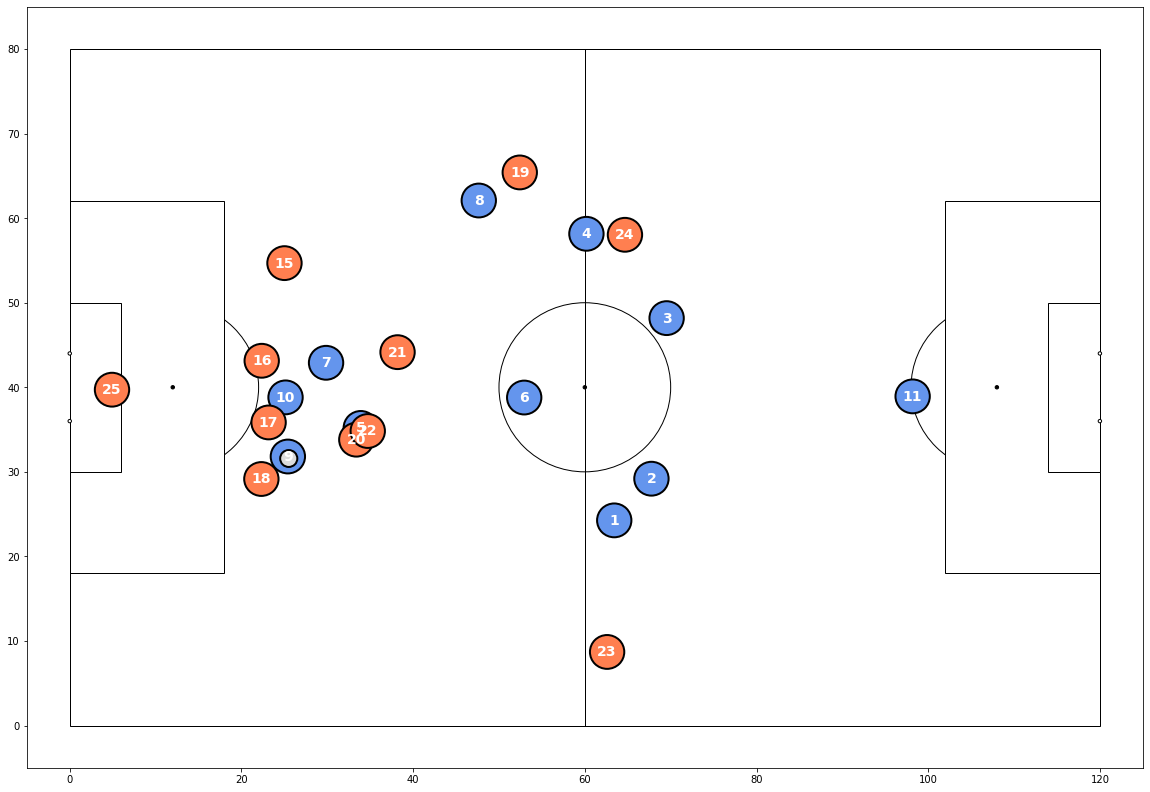

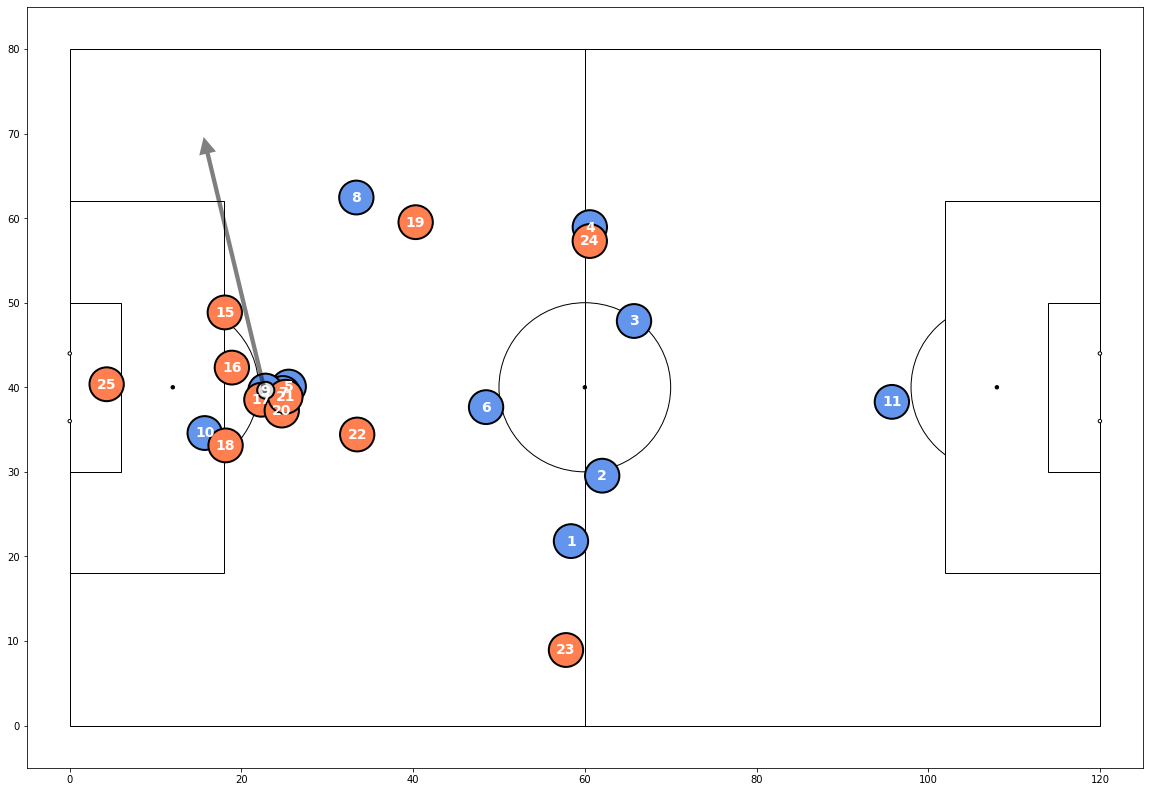

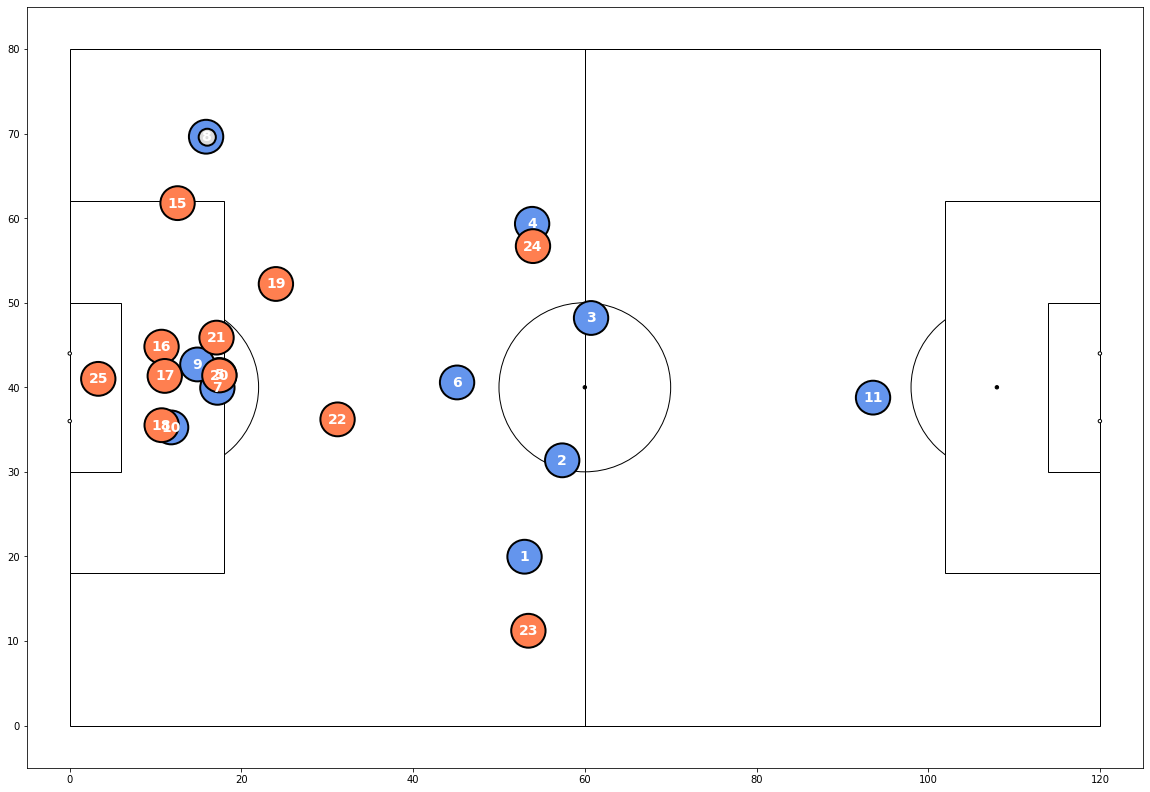

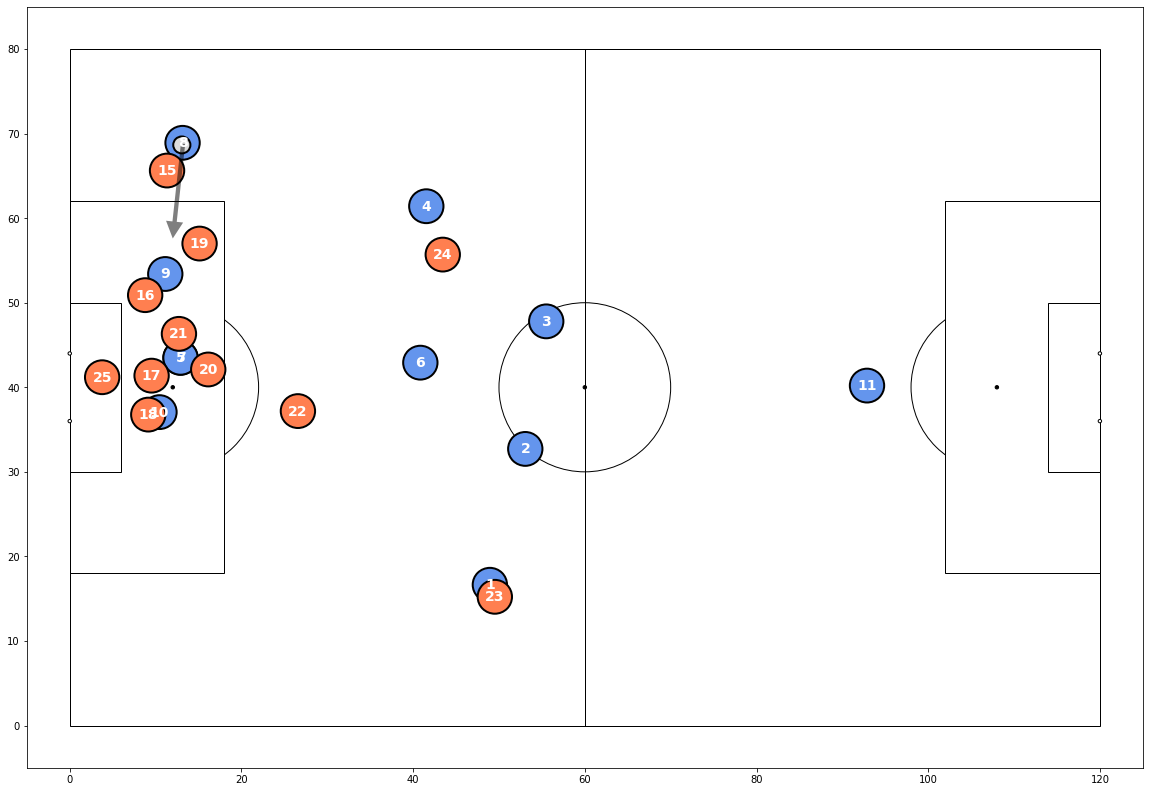

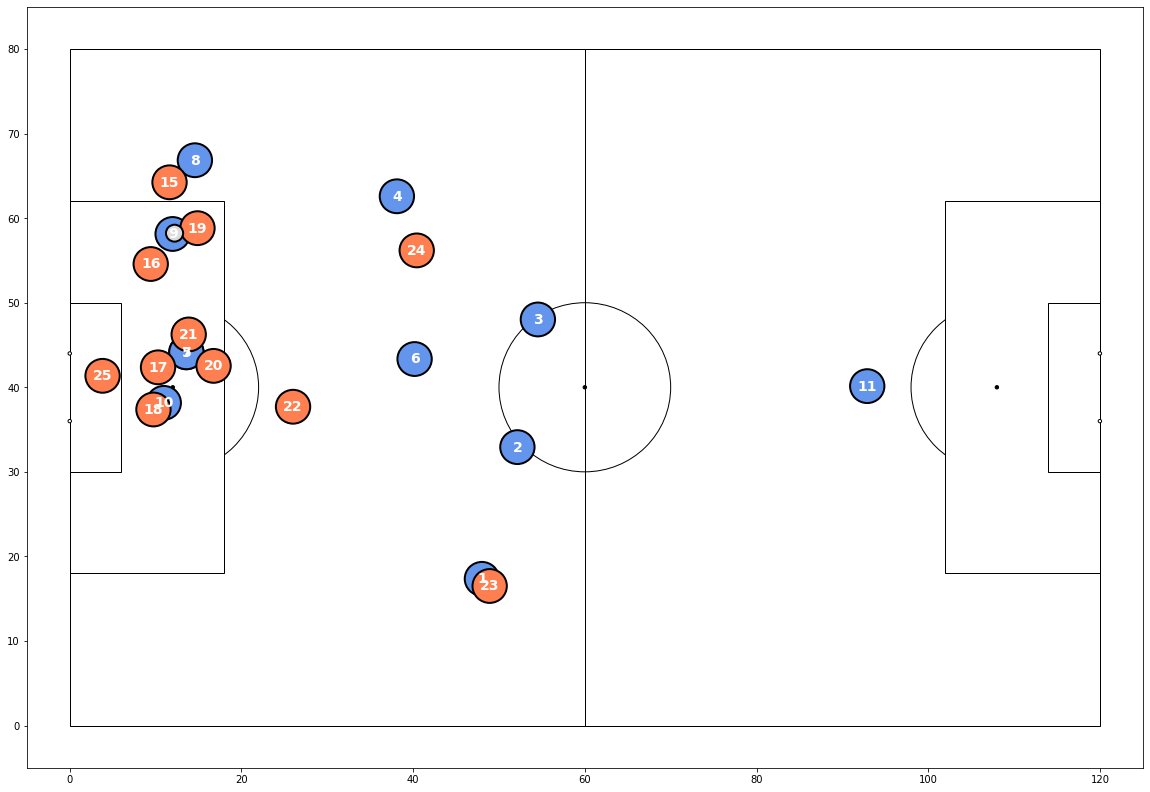

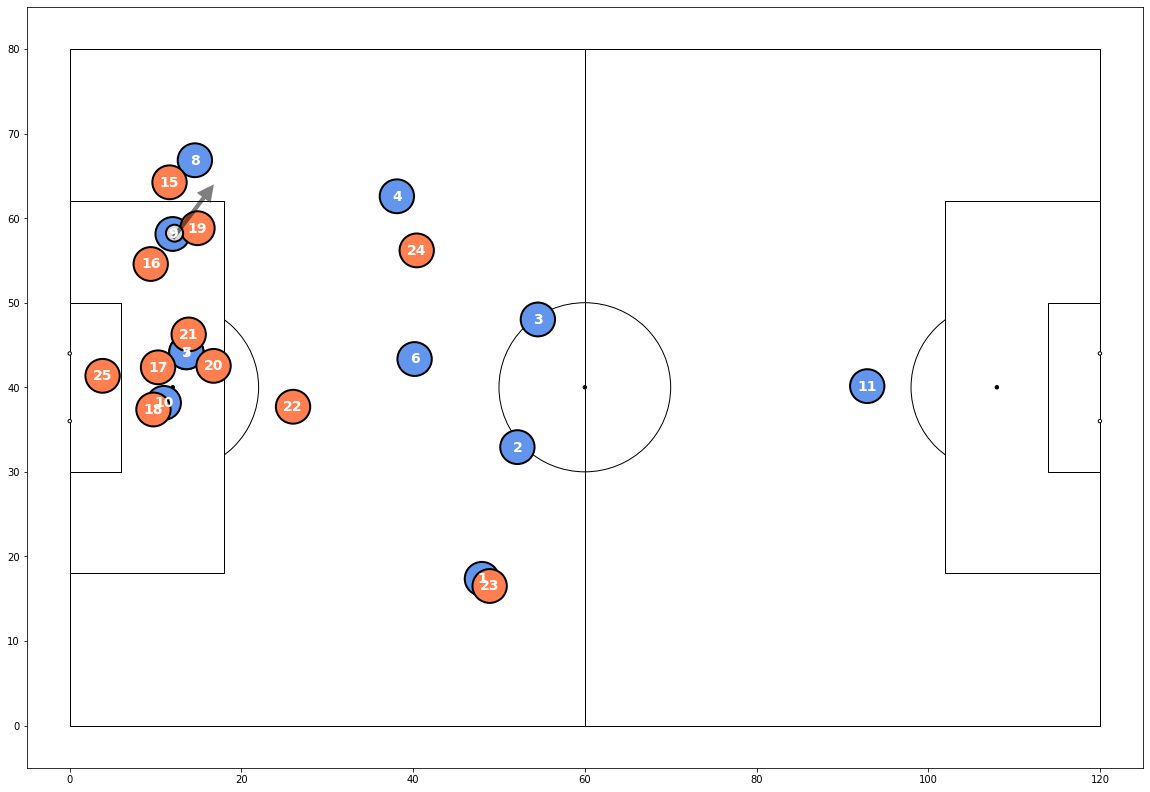

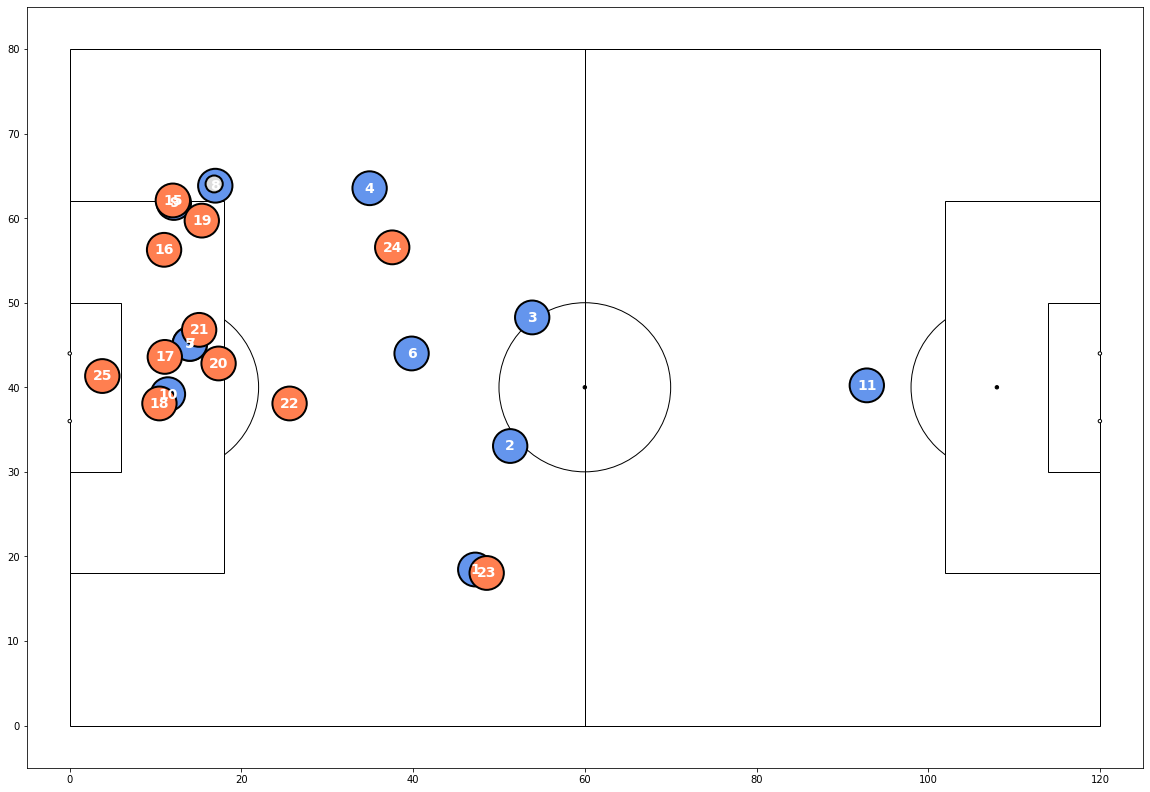

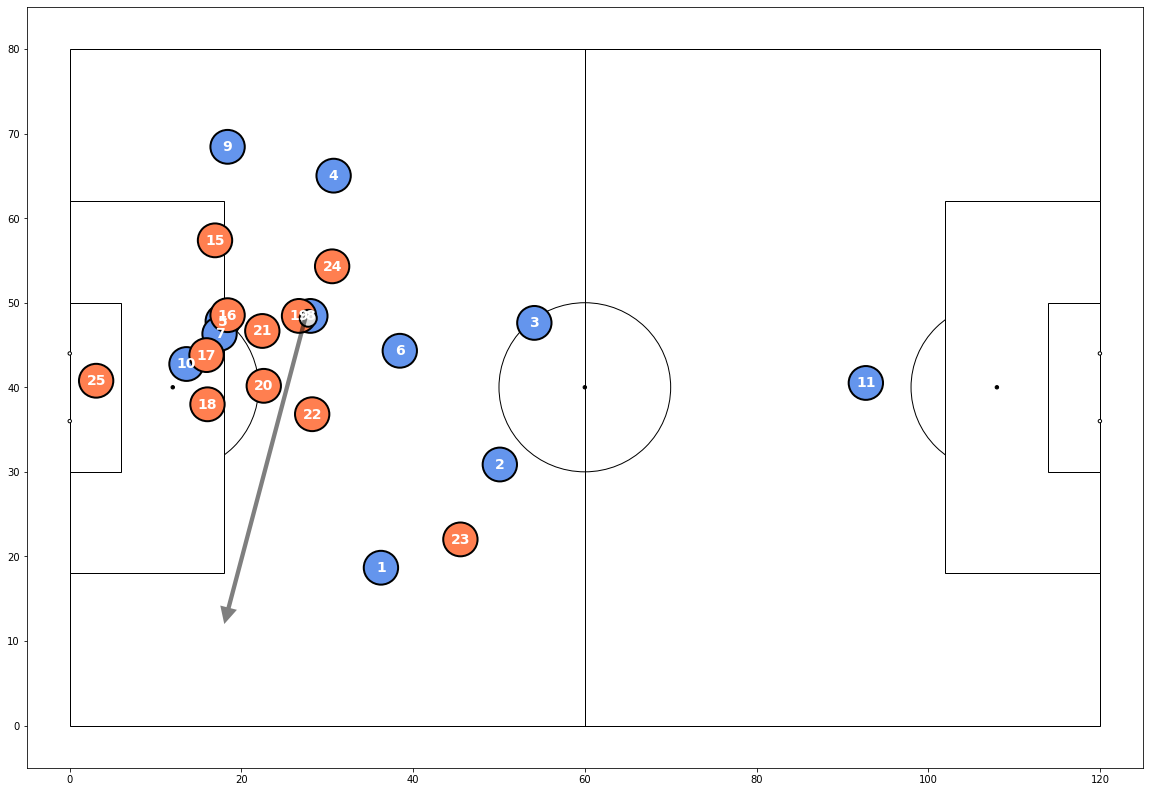

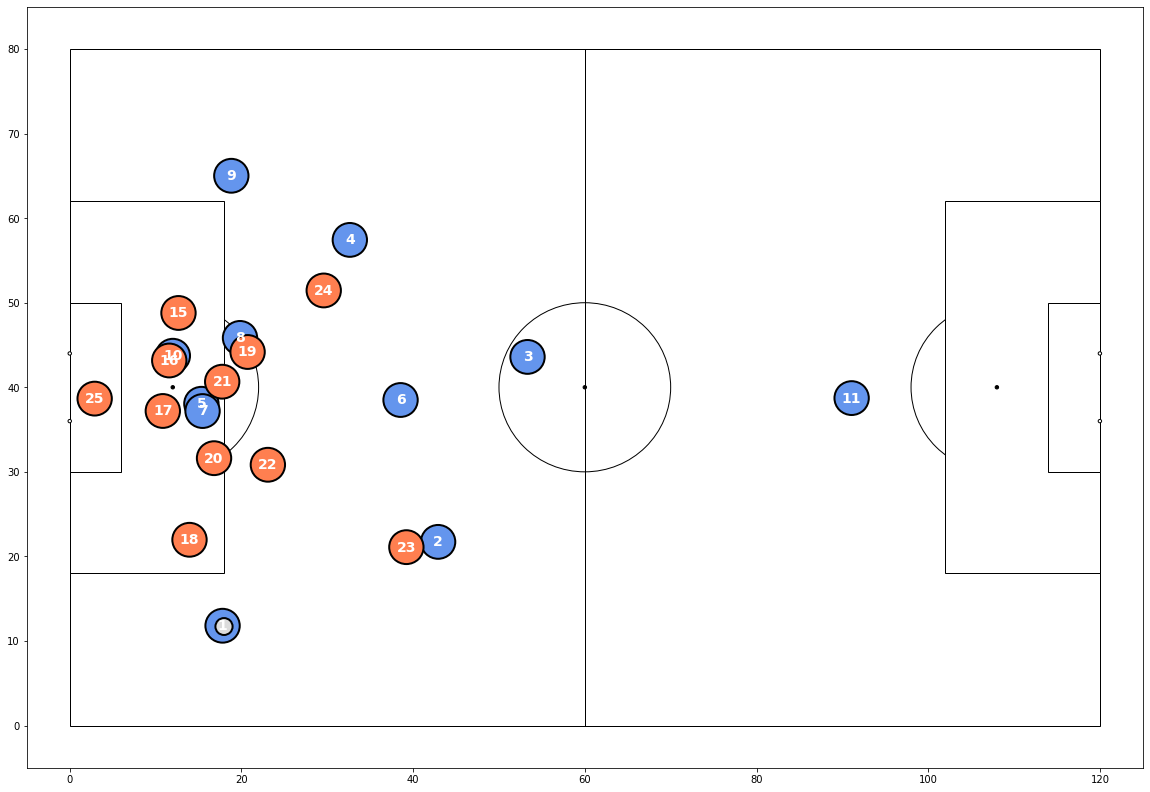

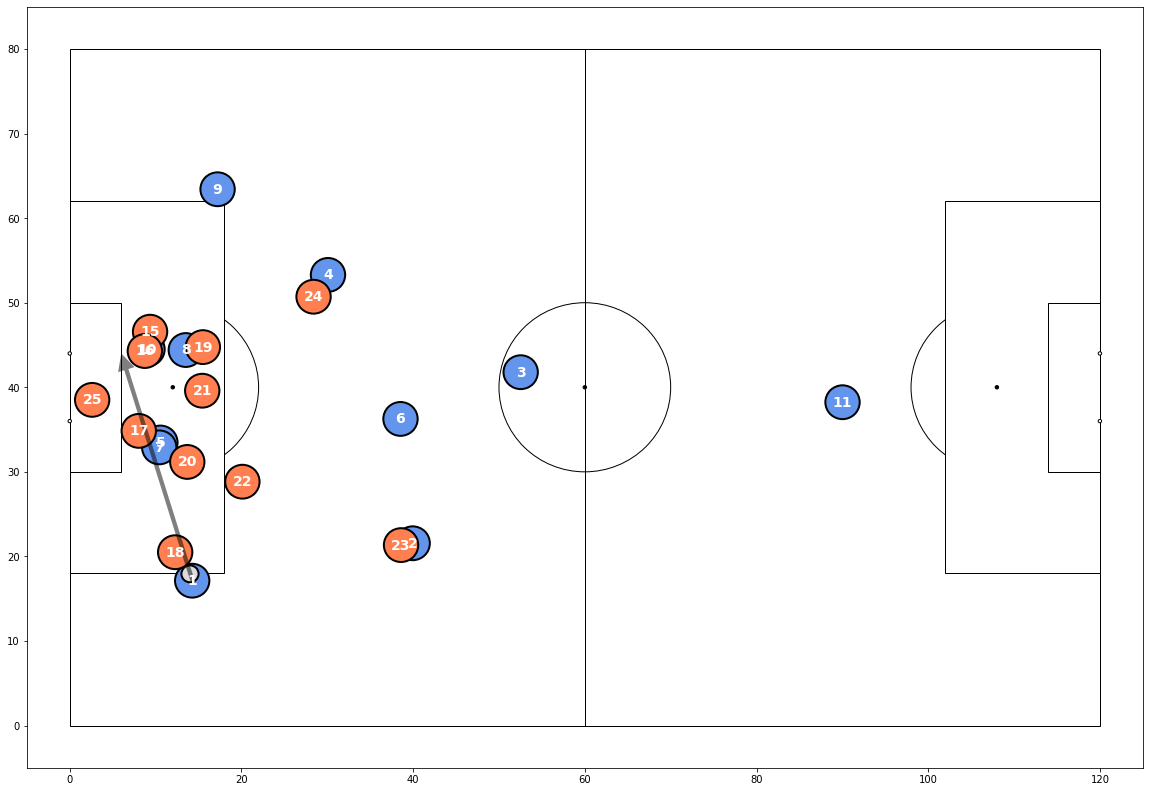

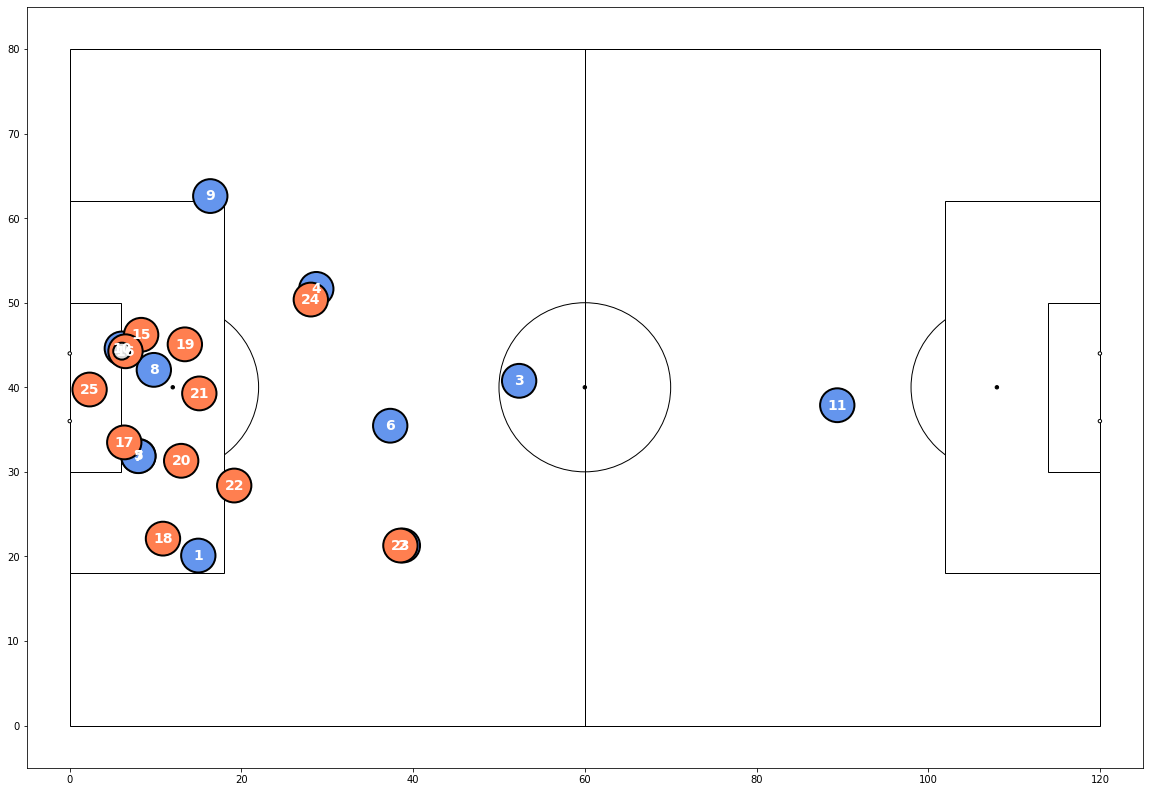

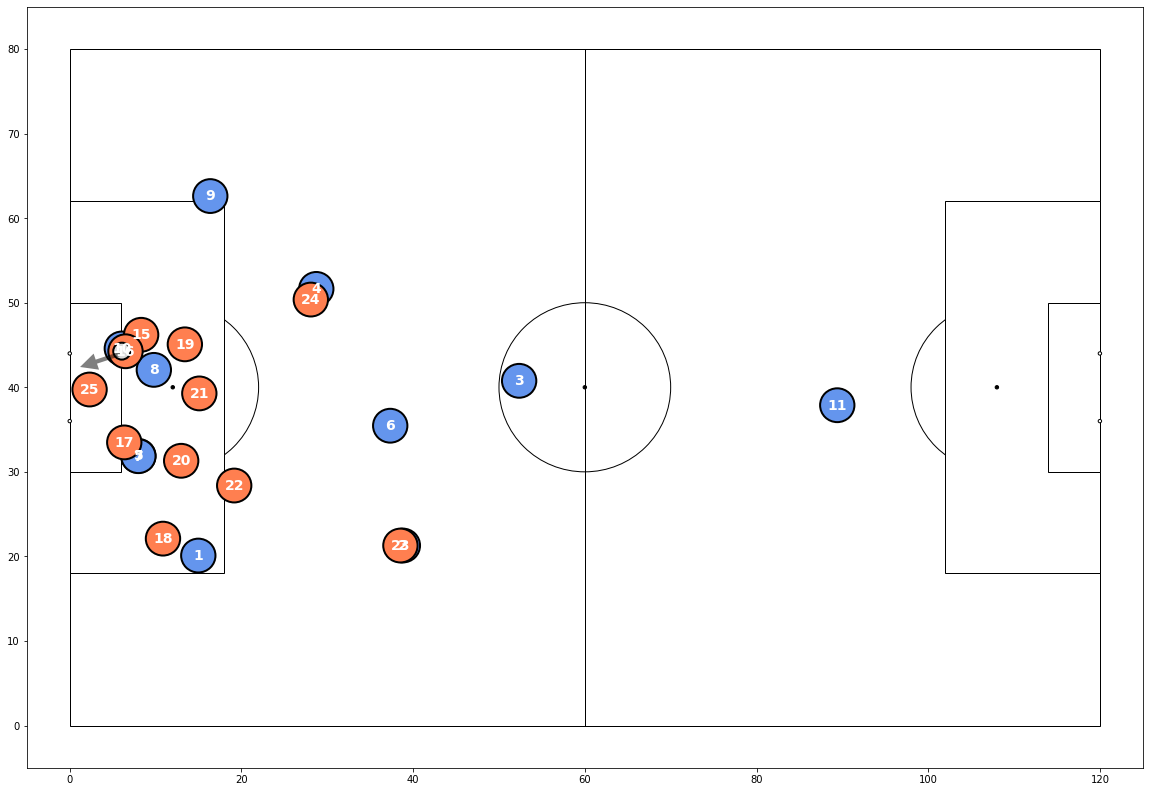

In [162]:
for event_idx in range(190, 198 + 1):
    plot_action(xmax_data = 1, ymax_data = 1, event = events.iloc[event_idx], frame_type = "start",
                home_tracking = home_tracking, away_tracking = away_tracking)
    plot_action(xmax_data = 1, ymax_data = 1, event = events.iloc[event_idx], frame_type = "end",
                home_tracking = home_tracking, away_tracking = away_tracking)

---